In [1]:
import Ab4Paper2023
import AbstractTrees
import Makie
import CairoMakie
using Statistics: cor
using AbstractTrees: PreOrderDFS

[ Info: Precompiling Ab4Paper2023 [5467c14f-b3bb-4772-a004-7e60c38dba4c]


In [2]:
root_full = Ab4Paper2023.experiment_with_targets();
data_full = Ab4Paper2023.Data(root_full);

In [ ]:
node_idx_full = Dict(n.label => t for (t, n) in enumerate(PreOrderDFS(root_full)));

In [ ]:
freqs = data_full.counts ./ sum(data_full.counts, dims=1);

Black: 0.9731364452683322
Blue: 

0.9820092648523927
Mix: 0.9727478111644364


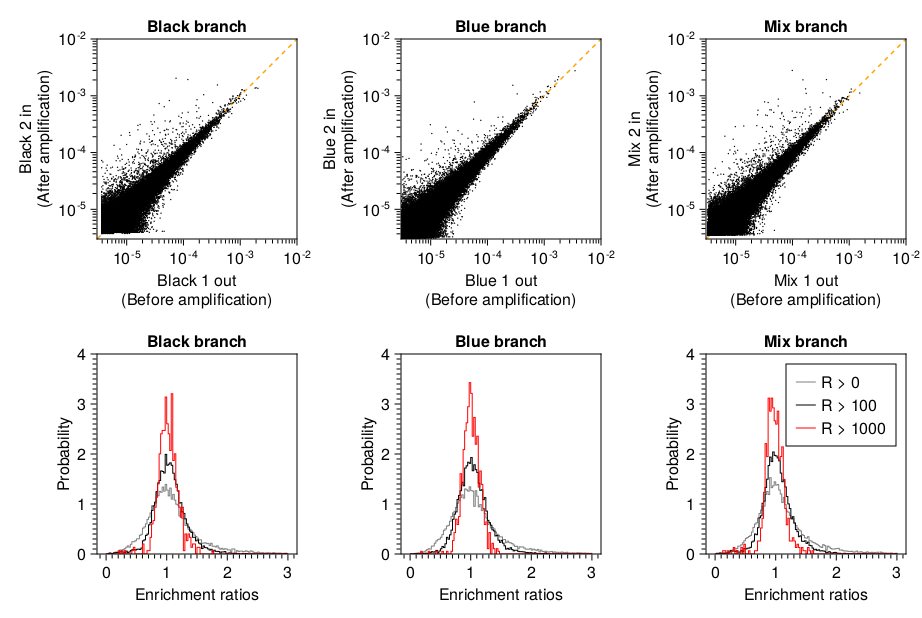

In [100]:
fig = Makie.Figure()

thresh_style = Dict(
    0 => (; markersize=5, color=:gray),
    50 => (; markersize=3, color=:black),
    200 => (; markersize=2, color=:red),
);

common_axis_config = (; width=200, height=200, xscale=log10, yscale=log10,
    xminorticksvisible = true, yminorticksvisible = true,
    xminorticks = Makie.IntervalsBetween(10), yminorticks = Makie.IntervalsBetween(10),
    xgridvisible=false, ygridvisible=false,
)

ax = Makie.Axis(fig[1,1]; common_axis_config..., 
    xlabel="Black 1 out\n(Before amplification)", ylabel="Black 2 in\n(After amplification)", title="Black branch")
Makie.lines!(ax, [1e-10,1], [1e-10,1], color=:orange, linestyle=:dash)
Makie.scatter!(ax, freqs[:, node_idx_full["black 1 o+"]], freqs[:, node_idx_full["black 2 in"]]; markersize=2, color=:black)
Makie.xlims!(ax, 3e-6, 1e-2)
Makie.ylims!(ax, 3e-6, 1e-2)
println("Black: ", cor(freqs[:, node_idx_full["black 1 o+"]], freqs[:, node_idx_full["black 2 in"]]))

ax = Makie.Axis(fig[1,2]; common_axis_config...,
    xlabel="Blue 1 out\n(Before amplification)", ylabel="Blue 2 in\n(After amplification)", title="Blue branch")
Makie.lines!(ax, [1e-10,1], [1e-10,1], color=:orange, linestyle=:dash)
Makie.scatter!(ax, freqs[:, node_idx_full["blue 1 o+"]], freqs[:, node_idx_full["blue 2 in"]]; markersize=2, color=:black)
Makie.xlims!(ax, 3e-6, 1e-2)
Makie.ylims!(ax, 3e-6, 1e-2)
println("Blue: ", cor(freqs[:, node_idx_full["blue 1 o+"]], freqs[:, node_idx_full["blue 2 in"]]))

ax = Makie.Axis(fig[1,3]; common_axis_config...,
    xlabel="Mix 1 out\n(Before amplification)", ylabel="Mix 2 in\n(After amplification)", title="Mix branch")
Makie.lines!(ax, [1e-10,1], [1e-10,1], color=:orange, linestyle=:dash)
Makie.scatter!(ax, freqs[:, node_idx_full["both 1 o+"]], freqs[:, node_idx_full["both 2 in"]]; markersize=2, color=:black)
Makie.xlims!(ax, 3e-6, 1e-2)
Makie.ylims!(ax, 3e-6, 1e-2)
println("Mix: ", cor(freqs[:, node_idx_full["both 1 o+"]], freqs[:, node_idx_full["both 2 in"]]))

# Histograms
thresh_style = Dict(
    0 => (; linewidth=1, color=:gray),
    #50 => (; linewidth=1, color=:black),
    100 => (; linewidth=1, color=:black),
    1000 => (; linewidth=1, color=:red),
);
_bins = 0:0.025:3

common_axis_config = (; width=200, height=200,
    xminorticksvisible = true, yminorticksvisible = true,
    xminorticks = Makie.IntervalsBetween(10), yminorticks = Makie.IntervalsBetween(10),
    xgridvisible=false, ygridvisible=false,
    xlabel="Enrichment ratios", ylabel="Probability"
)

ax_black = Makie.Axis(fig[2,1]; common_axis_config..., title="Black branch")
ax_blue = Makie.Axis(fig[2,2]; common_axis_config..., title="Blue branch")
ax_mix = Makie.Axis(fig[2,3]; common_axis_config..., title="Mix branch")
for thresh in [0, 100, 1000]
    _filter = (
        (data_full.counts[:, node_idx_full["black 1 o+"]] .> thresh) .&
        (data_full.counts[:, node_idx_full["black 2 in"]] .> thresh)
    )
    θ = freqs[_filter, node_idx_full["black 1 o+"]] ./ freqs[_filter, node_idx_full["black 2 in"]]
    Makie.stephist!(ax_black, θ; thresh_style[thresh]..., normalization=:pdf, bins=_bins)

    _filter = (
        (data_full.counts[:, node_idx_full["blue 1 o+"]] .> thresh) .&
        (data_full.counts[:, node_idx_full["blue 2 in"]] .> thresh)
    )
    θ = freqs[_filter, node_idx_full["blue 1 o+"]] ./ freqs[_filter, node_idx_full["blue 2 in"]]
    Makie.stephist!(ax_blue, θ; thresh_style[thresh]..., normalization=:pdf, bins=_bins)

    _filter = (
        (data_full.counts[:, node_idx_full["both 1 o+"]] .> thresh) .&
        (data_full.counts[:, node_idx_full["both 2 in"]] .> thresh)
    )
    θ = freqs[_filter, node_idx_full["both 1 o+"]] ./ freqs[_filter, node_idx_full["both 2 in"]]
    Makie.stephist!(ax_mix, θ; thresh_style[thresh]..., normalization=:pdf, bins=_bins, label="R > $thresh")
end
for ax in [ax_black, ax_blue, ax_mix]
    Makie.ylims!(ax, 0, 4)
end
Makie.axislegend(ax_mix)

Makie.resize_to_layout!(fig)
Makie.save("figures/amplification_bias.pdf", fig)
fig